In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 10
    n_geographic_split = 24
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by latlon_section')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('latlon_section')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest', 'fold']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training fold']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    data.loc[val_ind, "fold"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development fold - fold {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation fold - fold {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training fold,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 3,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 3,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 4,37.32%,48.77%,6.38%,2.09%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['fold'].value_counts())

train_data = data[data['fold'].isin([i for i in range(CFG.num_split // 2)])]
test_data = data[~data['fold'].isin([i for i in range(CFG.num_split // 2)])]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
1.0    113887
0.0    113887
2.0    113882
3.0    113882
5.0    113881
4.0    113881
6.0    113881
8.0    113877
9.0    113877
7.0    113877
Name: fold, dtype: int64
Train data: 
Num of data: 569419
Num of unique id: 569419
Num of unique poi: 369990
Mean num of unique poi: 1.5390118651855456
Test data: 
Num of data: 569393
Num of unique id: 569393
Num of unique poi: 369982
Mean num of unique poi: 1.5389748690476834
set()
set()


#Add new geographic coordinate classification

In [ ]:
latitude = [-90 + 180 / (CFG.n_geographic_split // 2) * i for i in range(1, CFG.n_geographic_split // 2)]
longitude = [-180 + 360 / CFG.n_geographic_split * i for i in range(CFG.n_geographic_split)]

In [ ]:
latlons = [(lat, lon) for lon in longitude for lat in latitude]
latlons.append((-90, 0))
latlons.append((90, 0))

In [ ]:
!pip install haversine
from haversine import haversine, Unit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def latlon_section(latlon):
    min_distance = float('inf')
    min_latlon = None
    for i in range(len(latlons)):
        distance = haversine(latlons[i], latlon)
        if distance < min_distance:
            min_distance = distance
            min_latlon = i
    return min_latlon
data['latlon_section'] = data[['latitude', 'longitude']].apply(latlon_section, axis = 1)
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1,5.0,140
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1,8.0,102
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0,4.0,215
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0,1.0,162
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1,5.0,140


<BarContainer object of 155 artists>

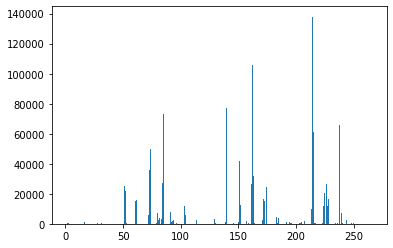

In [ ]:
plt.bar(data['latlon_section'].value_counts().index, data['latlon_section'].value_counts())

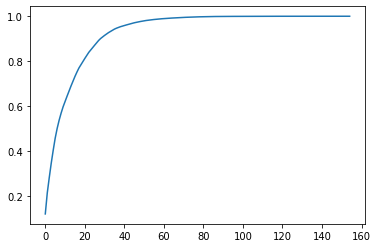

In [ ]:
counts = np.array(data['latlon_section'].value_counts())
counts_sum = counts.sum()
counts = np.sort(counts)[::-1]
plt.plot(np.arange(len(counts)), np.cumsum(counts) / counts_sum)

In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)]), col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.num_neighbors)
test_data = recall_knn(data.loc[~data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by latlon_section


  0%|          | 0/143 [00:00<?, ?it/s]

Start knn
Start knn grouped by latlon_section


  0%|          | 0/143 [00:00<?, ?it/s]

Start knn
Num of unique id: 569419
Num of train data: 13609375
Pos rate: 0.07400134098737084
                        id          match_id     kdist  kneighbors  \
1847610   E_3e9cb77fe8f10e  E_54f8e37bb0b727  0.001875         3.0   
8636400   E_2aaaefdab2f172  E_aba6e8f18560ec  0.001980        15.0   
2142514   E_c32ede28de0ef6  E_d356641dbe1655  0.006252         3.0   
6698090   E_c34c624ec2e0b3  E_79430071f0b343  0.006480        11.0   
10748445  E_e024264d50487b  E_4d049e5fa4d1ff  0.010776        18.0   

         point_of_interest  fold  kdist_country  kneighbors_country  \
1847610   P_42c290ec4e0b63   0.0       0.001814                 3.0   
8636400                NaN   NaN            NaN                 NaN   
2142514   P_7b3431f612b3c9   0.0       0.006201                 3.0   
6698090   P_b338881408e68e   3.0       0.006475                19.0   
10748445               NaN   NaN            NaN                 NaN   

          kdist_diff  kneighbors_mean  label  
1847610     

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9227314800219812


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0502522
[100]	valid_0's binary_logloss: 0.0485027
[150]	valid_0's binary_logloss: 0.0477686
[200]	valid_0's binary_logloss: 0.0473587
[250]	valid_0's binary_logloss: 0.0470569
[300]	valid_0's binary_logloss: 0.0467677
[350]	valid_0's binary_logloss: 0.0465671
[400]	valid_0's binary_logloss: 0.0464068
[450]	valid_0's binary_logloss: 0.0462413
[500]	valid_0's binary_logloss: 0.0461598
[550]	valid_0's binary_logloss: 0.0460195
[600]	valid_0's binary_logloss: 0.0459037
[650]	valid_0's binary_logloss: 0.0458311
[700]	valid_0's binary_logloss: 0.0457542
[750]	valid_0's binary_logloss: 0.0456775
[800]	valid_0's binary_logloss: 0.0455856
[850]	valid_0's binary_logloss: 0.0455061
[900]	valid_0's binary_logloss: 0.0454513
[950]	valid_0's binary_logloss: 0.0453855
[1000]	valid_0's binary_logloss: 0.0453248
[1050]	valid_0's binary_logloss: 0.0452716
[1100]	valid_0's binary_logloss: 0.0451981
[1150]	valid_0's binary_logloss: 0.0451577
[1200]	valid_0's binary_logloss

In [ ]:
del train_data
gc.collect()

87

#Check Feature Importances

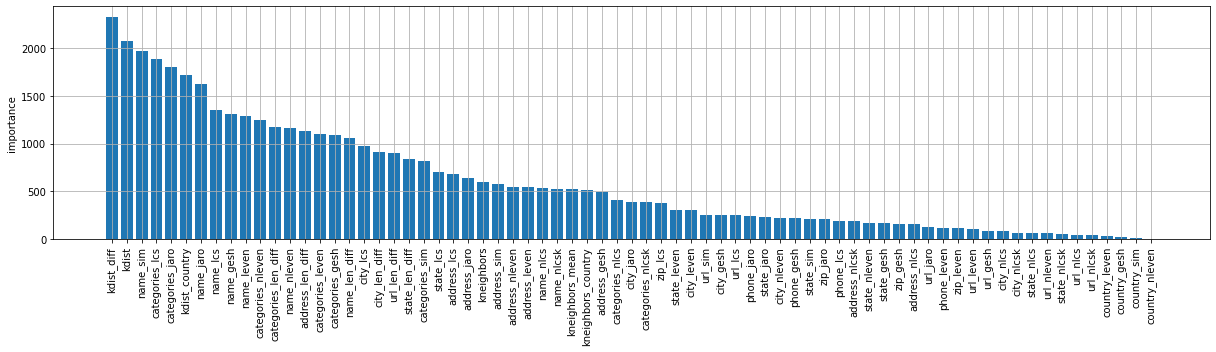

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-24 23:03:00,234] A new study created in memory with name: no-name-63f40f0f-5ea2-4d2f-9f9a-409aeb17e4a5
[I 2022-05-24 23:03:33,507] Trial 0 finished with value: 0.7585847863271392 and parameters: {'threshold': 0.10660984703348653}. Best is trial 0 with value: 0.7585847863271392.


CV: 0.758585


[I 2022-05-24 23:03:52,842] Trial 1 finished with value: 0.8189236554890748 and parameters: {'threshold': 0.7469293645915731}. Best is trial 1 with value: 0.8189236554890748.


CV: 0.818924


[I 2022-05-24 23:04:12,353] Trial 2 finished with value: 0.7978877207579848 and parameters: {'threshold': 0.8699864259006821}. Best is trial 1 with value: 0.8189236554890748.


CV: 0.797888


[I 2022-05-24 23:04:35,721] Trial 3 finished with value: 0.7664044866517793 and parameters: {'threshold': 0.940437013719376}. Best is trial 1 with value: 0.8189236554890748.


CV: 0.766404


[I 2022-05-24 23:04:55,902] Trial 4 finished with value: 0.82692536818707 and parameters: {'threshold': 0.6047380392905726}. Best is trial 4 with value: 0.82692536818707.


CV: 0.826925


[I 2022-05-24 23:05:14,316] Trial 5 finished with value: 0.8020977679660213 and parameters: {'threshold': 0.85442416084579}. Best is trial 4 with value: 0.82692536818707.


CV: 0.802098


[I 2022-05-24 23:05:33,083] Trial 6 finished with value: 0.7669870159101815 and parameters: {'threshold': 0.9396499721606624}. Best is trial 4 with value: 0.82692536818707.


CV: 0.766987


[I 2022-05-24 23:05:54,514] Trial 7 finished with value: 0.7901888181988054 and parameters: {'threshold': 0.18376263968934348}. Best is trial 4 with value: 0.82692536818707.


CV: 0.790189


[I 2022-05-24 23:06:15,934] Trial 8 finished with value: 0.7360979504459528 and parameters: {'threshold': 0.07587343345082354}. Best is trial 4 with value: 0.82692536818707.


CV: 0.736098


[I 2022-05-24 23:06:35,300] Trial 9 finished with value: 0.812691015225217 and parameters: {'threshold': 0.8000432949148354}. Best is trial 4 with value: 0.82692536818707.


CV: 0.812691


[I 2022-05-24 23:06:55,446] Trial 10 finished with value: 0.8265912288497388 and parameters: {'threshold': 0.49227068731494683}. Best is trial 4 with value: 0.82692536818707.


CV: 0.826591


[I 2022-05-24 23:07:15,667] Trial 11 finished with value: 0.8257942797672665 and parameters: {'threshold': 0.46838620849370055}. Best is trial 4 with value: 0.82692536818707.


CV: 0.825794


[I 2022-05-24 23:07:34,784] Trial 12 finished with value: 0.8272922697379149 and parameters: {'threshold': 0.5292262606791487}. Best is trial 12 with value: 0.8272922697379149.


CV: 0.827292


[I 2022-05-24 23:07:54,584] Trial 13 finished with value: 0.8259095733436865 and parameters: {'threshold': 0.6412969655595211}. Best is trial 12 with value: 0.8272922697379149.


CV: 0.825910


[I 2022-05-24 23:08:15,158] Trial 14 finished with value: 0.8102828774731348 and parameters: {'threshold': 0.28157095251138886}. Best is trial 12 with value: 0.8272922697379149.


CV: 0.810283


[I 2022-05-24 23:08:36,391] Trial 15 finished with value: 0.8261520714522567 and parameters: {'threshold': 0.6324304195875513}. Best is trial 12 with value: 0.8272922697379149.


CV: 0.826152


[I 2022-05-24 23:08:57,019] Trial 16 finished with value: 0.8187597460599002 and parameters: {'threshold': 0.35334310849350653}. Best is trial 12 with value: 0.8272922697379149.


CV: 0.818760
CV: 0.826530


[I 2022-05-24 23:09:16,220] Trial 17 finished with value: 0.826530248379776 and parameters: {'threshold': 0.6226875682689283}. Best is trial 12 with value: 0.8272922697379149.
[I 2022-05-24 23:09:45,675] Trial 18 finished with value: 0.8216381972149224 and parameters: {'threshold': 0.38978269635563756}. Best is trial 12 with value: 0.8272922697379149.


CV: 0.821638


[I 2022-05-24 23:10:05,013] Trial 19 finished with value: 0.827460020519505 and parameters: {'threshold': 0.5647486592251877}. Best is trial 19 with value: 0.827460020519505.


CV: 0.827460


[I 2022-05-24 23:10:24,653] Trial 20 finished with value: 0.8210794723955048 and parameters: {'threshold': 0.7227455355097775}. Best is trial 19 with value: 0.827460020519505.


CV: 0.821079


[I 2022-05-24 23:10:44,819] Trial 21 finished with value: 0.8274579845466334 and parameters: {'threshold': 0.5665416763147223}. Best is trial 19 with value: 0.827460020519505.


CV: 0.827458


[I 2022-05-24 23:11:04,024] Trial 22 finished with value: 0.8274826185057925 and parameters: {'threshold': 0.5537020373239361}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827483


[I 2022-05-24 23:11:24,012] Trial 23 finished with value: 0.827286882437135 and parameters: {'threshold': 0.5328597889415857}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827287


[I 2022-05-24 23:11:44,406] Trial 24 finished with value: 0.8232592373588935 and parameters: {'threshold': 0.4129443332088665}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.823259


[I 2022-05-24 23:12:05,207] Trial 25 finished with value: 0.8111821888744709 and parameters: {'threshold': 0.2874116947132162}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.811182


[I 2022-05-24 23:12:24,135] Trial 26 finished with value: 0.8231946748365222 and parameters: {'threshold': 0.6953579309518376}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.823195


[I 2022-05-24 23:12:45,150] Trial 27 finished with value: 0.8274586136445445 and parameters: {'threshold': 0.5637116874308374}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827459


[I 2022-05-24 23:13:05,526] Trial 28 finished with value: 0.8246753929886461 and parameters: {'threshold': 0.4399161443918713}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.824675


[I 2022-05-24 23:13:25,365] Trial 29 finished with value: 0.8153988551653722 and parameters: {'threshold': 0.32065620586155386}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.815399


[I 2022-05-24 23:13:46,342] Trial 30 finished with value: 0.7999073234993679 and parameters: {'threshold': 0.2232605925819453}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.799907


[I 2022-05-24 23:14:05,580] Trial 31 finished with value: 0.8274599238370126 and parameters: {'threshold': 0.5649117587769932}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827460


[I 2022-05-24 23:14:25,533] Trial 32 finished with value: 0.8274679171728999 and parameters: {'threshold': 0.556431525497729}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827468


[I 2022-05-24 23:14:45,250] Trial 33 finished with value: 0.8249377998912687 and parameters: {'threshold': 0.6642450317217574}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.824938


[I 2022-05-24 23:15:17,134] Trial 34 finished with value: 0.4329201313297393 and parameters: {'threshold': 0.004184538937749005}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.432920


[I 2022-05-24 23:15:36,666] Trial 35 finished with value: 0.8198217493719516 and parameters: {'threshold': 0.7365441911296176}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.819822


[I 2022-05-24 23:15:55,737] Trial 36 finished with value: 0.8272061000870621 and parameters: {'threshold': 0.5856780115010183}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827206


[I 2022-05-24 23:16:15,155] Trial 37 finished with value: 0.8144452765651162 and parameters: {'threshold': 0.7876154836681174}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.814445


[I 2022-05-24 23:16:34,419] Trial 38 finished with value: 0.8263885401979139 and parameters: {'threshold': 0.4828242809771021}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.826389


[I 2022-05-24 23:16:54,328] Trial 39 finished with value: 0.8272887983150464 and parameters: {'threshold': 0.5303893876972738}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827289


[I 2022-05-24 23:17:14,033] Trial 40 finished with value: 0.8239973472537284 and parameters: {'threshold': 0.6821770094051759}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.823997


[I 2022-05-24 23:17:33,096] Trial 41 finished with value: 0.8272776267428825 and parameters: {'threshold': 0.5803978452280402}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827278


[I 2022-05-24 23:17:53,088] Trial 42 finished with value: 0.8250393655706362 and parameters: {'threshold': 0.448402124430985}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.825039


[I 2022-05-24 23:18:12,885] Trial 43 finished with value: 0.8274726909317228 and parameters: {'threshold': 0.5560060675262042}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827473


[I 2022-05-24 23:18:32,904] Trial 44 finished with value: 0.827308653764219 and parameters: {'threshold': 0.5281624918992252}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827309


[I 2022-05-24 23:18:51,509] Trial 45 finished with value: 0.8120173892426751 and parameters: {'threshold': 0.8044085767608514}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.812017


[I 2022-05-24 23:19:11,172] Trial 46 finished with value: 0.8268307154763114 and parameters: {'threshold': 0.6117999252196608}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.826831


[I 2022-05-24 23:19:31,460] Trial 47 finished with value: 0.8208972489445517 and parameters: {'threshold': 0.3795877079610709}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.820897


[I 2022-05-24 23:19:59,024] Trial 48 finished with value: 0.7893572768003327 and parameters: {'threshold': 0.8962440637745523}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.789357


[I 2022-05-24 23:20:22,760] Trial 49 finished with value: 0.8263021537090477 and parameters: {'threshold': 0.4808912448946016}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.826302


[I 2022-05-24 23:20:42,468] Trial 50 finished with value: 0.8256918666206754 and parameters: {'threshold': 0.64814891984831}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.825692


[I 2022-05-24 23:21:02,431] Trial 51 finished with value: 0.8274792551210666 and parameters: {'threshold': 0.5528746882672005}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827479


[I 2022-05-24 23:21:22,624] Trial 52 finished with value: 0.8270903623762392 and parameters: {'threshold': 0.5162916575226153}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827090


[I 2022-05-24 23:21:43,028] Trial 53 finished with value: 0.8244164458659814 and parameters: {'threshold': 0.43441958722216495}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.824416


[I 2022-05-24 23:22:02,291] Trial 54 finished with value: 0.8274018717491181 and parameters: {'threshold': 0.568354687315968}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.827402


[I 2022-05-24 23:22:22,344] Trial 55 finished with value: 0.8269415416571868 and parameters: {'threshold': 0.607721097715704}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.826942


[I 2022-05-24 23:22:41,751] Trial 56 finished with value: 0.8265844045398407 and parameters: {'threshold': 0.49232630894529694}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.826584


[I 2022-05-24 23:23:01,443] Trial 57 finished with value: 0.8225987983509796 and parameters: {'threshold': 0.703747868107961}. Best is trial 22 with value: 0.8274826185057925.


CV: 0.822599


[I 2022-05-24 23:23:21,506] Trial 58 finished with value: 0.8275015478195835 and parameters: {'threshold': 0.5551037741600304}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827502


[I 2022-05-24 23:23:40,379] Trial 59 finished with value: 0.8251543461154207 and parameters: {'threshold': 0.6603989211863904}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.825154


[I 2022-05-24 23:24:00,360] Trial 60 finished with value: 0.827324375925111 and parameters: {'threshold': 0.5398173433088835}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827324


[I 2022-05-24 23:24:20,331] Trial 61 finished with value: 0.8263395667877426 and parameters: {'threshold': 0.6284263616691637}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.826340


[I 2022-05-24 23:24:37,731] Trial 62 finished with value: 0.6961478491753461 and parameters: {'threshold': 0.9926680917861256}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.696148


[I 2022-05-24 23:24:57,981] Trial 63 finished with value: 0.8274775277689407 and parameters: {'threshold': 0.557235863363609}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827478


[I 2022-05-24 23:25:17,365] Trial 64 finished with value: 0.826820464926747 and parameters: {'threshold': 0.5028094632444392}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.826820


[I 2022-05-24 23:25:37,596] Trial 65 finished with value: 0.8252925828842566 and parameters: {'threshold': 0.4544756622529647}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.825293


[I 2022-05-24 23:25:58,086] Trial 66 finished with value: 0.8228659995441722 and parameters: {'threshold': 0.40692766591771246}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.822866


[I 2022-05-24 23:26:17,183] Trial 67 finished with value: 0.8271237765230988 and parameters: {'threshold': 0.5898914955456449}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827124


[I 2022-05-24 23:26:37,151] Trial 68 finished with value: 0.8274858522935951 and parameters: {'threshold': 0.5600306838725219}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827486


[I 2022-05-24 23:26:57,249] Trial 69 finished with value: 0.8274651686094232 and parameters: {'threshold': 0.5478126839454799}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827465


[I 2022-05-24 23:27:16,029] Trial 70 finished with value: 0.8173328719129788 and parameters: {'threshold': 0.763642100966604}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.817333


[I 2022-05-24 23:27:36,109] Trial 71 finished with value: 0.8274433705202796 and parameters: {'threshold': 0.5458946734539937}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827443


[I 2022-05-24 23:27:56,098] Trial 72 finished with value: 0.8268806530789152 and parameters: {'threshold': 0.6102135327743696}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.826881


[I 2022-05-24 23:28:16,278] Trial 73 finished with value: 0.8267446255658987 and parameters: {'threshold': 0.5005842511040283}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.826745


[I 2022-05-24 23:28:35,595] Trial 74 finished with value: 0.8274823977499358 and parameters: {'threshold': 0.5497609807608426}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827482


[I 2022-05-24 23:28:55,877] Trial 75 finished with value: 0.8259144723724254 and parameters: {'threshold': 0.4721056529823233}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.825914


[I 2022-05-24 23:29:14,886] Trial 76 finished with value: 0.8260587820374361 and parameters: {'threshold': 0.6368507402105543}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.826059


[I 2022-05-24 23:29:34,803] Trial 77 finished with value: 0.8270836177793388 and parameters: {'threshold': 0.5931071860951649}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827084


[I 2022-05-24 23:29:54,112] Trial 78 finished with value: 0.8270831386104028 and parameters: {'threshold': 0.516860737820793}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827083


[I 2022-05-24 23:30:15,251] Trial 79 finished with value: 0.8237806476737849 and parameters: {'threshold': 0.42139878220352145}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.823781


[I 2022-05-24 23:30:46,265] Trial 80 finished with value: 0.8241656420779448 and parameters: {'threshold': 0.6797462439198133}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.824166


[I 2022-05-24 23:31:07,943] Trial 81 finished with value: 0.8273637412350735 and parameters: {'threshold': 0.5424040830705795}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827364


[I 2022-05-24 23:31:28,006] Trial 82 finished with value: 0.8274713383842386 and parameters: {'threshold': 0.5483279912599424}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827471


[I 2022-05-24 23:31:48,084] Trial 83 finished with value: 0.8274030046513239 and parameters: {'threshold': 0.5679655572831447}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827403


[I 2022-05-24 23:32:08,671] Trial 84 finished with value: 0.8253137601822156 and parameters: {'threshold': 0.45487747202387363}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.825314


[I 2022-05-24 23:32:28,027] Trial 85 finished with value: 0.8270761398436302 and parameters: {'threshold': 0.5941282847480825}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827076


[I 2022-05-24 23:32:48,293] Trial 86 finished with value: 0.8269371377405185 and parameters: {'threshold': 0.5099525794014127}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.826937


[I 2022-05-24 23:33:08,310] Trial 87 finished with value: 0.8265746008434415 and parameters: {'threshold': 0.6210011679568828}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.826575


[I 2022-05-24 23:33:28,217] Trial 88 finished with value: 0.8194876073649592 and parameters: {'threshold': 0.3619174726812995}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.819488


[I 2022-05-24 23:33:48,428] Trial 89 finished with value: 0.8262241414419952 and parameters: {'threshold': 0.4798382056916789}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.826224


[I 2022-05-24 23:34:08,484] Trial 90 finished with value: 0.8274832407578169 and parameters: {'threshold': 0.5527456091607488}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827483


[I 2022-05-24 23:34:28,714] Trial 91 finished with value: 0.8274815548617975 and parameters: {'threshold': 0.5585822884174293}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827482


[I 2022-05-24 23:34:47,962] Trial 92 finished with value: 0.8273651878208877 and parameters: {'threshold': 0.5757008932289167}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827365


[I 2022-05-24 23:35:08,247] Trial 93 finished with value: 0.8272953180969317 and parameters: {'threshold': 0.5292441784805263}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827295


[I 2022-05-24 23:35:27,441] Trial 94 finished with value: 0.8258909154952342 and parameters: {'threshold': 0.6424012958886445}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.825891


[I 2022-05-24 23:35:47,365] Trial 95 finished with value: 0.8274946342380566 and parameters: {'threshold': 0.5613692005963613}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827495


[I 2022-05-24 23:36:07,286] Trial 96 finished with value: 0.8248551568368166 and parameters: {'threshold': 0.6661520589502149}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.824855


[I 2022-05-24 23:36:26,578] Trial 97 finished with value: 0.8269482588759978 and parameters: {'threshold': 0.6068343193804091}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.826948


[I 2022-05-24 23:36:46,721] Trial 98 finished with value: 0.8268458401140146 and parameters: {'threshold': 0.5042259244670232}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.826846


[I 2022-05-24 23:37:08,304] Trial 99 finished with value: 0.8272734552917717 and parameters: {'threshold': 0.5816444861598088}. Best is trial 58 with value: 0.8275015478195835.


CV: 0.827273


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5551037741600304

In [ ]:
study.best_value

0.8275015478195835

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.827502


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,143043.000000,143043.000000,139457.000000,139457.000000,139457.000000,134697.000000,147060.000000,147060.0,147060.000000,147060.000000,...,147060.000000,147057.000000,147057.000000,147057.000000,147057.000000,147060.000000,147057.000000,147057.000000,147057.000000,1.470600e+05
mean,0.005719,6.239334,6.952136,0.003173,6.235521,0.412054,6.513379,1.0,0.259592,0.408723,...,0.999123,0.999187,0.001680,0.999161,1.998375,0.000020,0.000840,0.999187,0.999187,2.116722e-01
std,0.036404,5.238836,1.427254,0.014568,5.232571,2.259658,5.304957,0.0,0.309904,0.251832,...,0.029605,0.028225,0.057876,0.028922,0.056450,0.004517,0.028938,0.028225,0.028225,1.743903e-01
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.036090e-07
25%,0.000452,2.000000,6.000000,0.000342,2.000000,0.006073,2.000000,1.0,0.000000,0.200000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,4.771881e-02
50%,0.001141,4.000000,7.000000,0.000886,4.000000,0.055207,5.000000,1.0,0.000000,0.387097,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.753904e-01
75%,0.003110,10.000000,8.000000,0.002470,10.000000,0.311430,10.000000,1.0,0.510607,0.588235,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,3.620306e-01
max,1.849236,19.000000,9.000000,1.755013,19.000000,170.784270,19.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,5.551033e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
769329,E_59d6462f5bd71a,E_aa68cf7250a99d,0.004725,1.0,P_809f1213e0189a,7.0,0.003524,1.0,0.340663,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.175985
877245,E_8a4cbd63fc6d07,E_055cb670f034bf,0.000032,1.0,P_cbf67fa82552f2,5.0,0.000032,1.0,0.007519,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.447535
1948797,E_6c2c0d5245a6ea,E_13c1104440517d,0.001507,3.0,P_498baa66fb1020,6.0,0.001507,3.0,0.000009,3.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.003401
1816853,E_30cc2a443169f1,E_acb9a55a4ed83e,0.000753,3.0,P_de00d39407dbf5,5.0,0.000648,5.0,0.161178,4.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.382663
614764,E_145cd935c88bb0,E_384fd3ca626fb3,0.000000,1.0,P_e105bd440edbaa,8.0,0.000000,1.0,NaN,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.065213
1633416,E_de3f3ad8dec9ef,E_e71a19128c99d0,0.000376,2.0,P_4e864176258158,9.0,0.000376,2.0,0.001704,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.517052
6060517,E_a4902f3d4003ab,E_d75b636e897230,0.001104,10.0,P_fa445a57cf1cf2,6.0,0.001103,10.0,0.001513,10.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.003787
2875915,E_0d00d2e3d691e6,E_6482c1e1c01a49,0.002874,5.0,P_76e12802973b33,6.0,0.002833,5.0,0.014520,5.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.150187
5109624,E_f944b6df101cd5,E_08ee0834492ba0,0.000194,8.0,P_aab187db71cff5,8.0,0.000194,8.0,0.000022,8.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.391921
10954417,E_3cffeb55f396dc,E_d4d9d735f082b8,0.071655,19.0,P_8f920c3d8d138a,6.0,0.063642,18.0,0.125903,18.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.104567


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
313577,E_46756eb3fd6b45,Eulji Myun Oak,1.317243,124.84534,NaN,NaN,NaN,NaN,ID,NaN,NaN,Korean Restaurants,P_e105bd440edbaa,4,8.0,225
662641,E_94e2a2ea459fce,Centrepoint Malls,1.317170,124.83806,NaN,NaN,NaN,NaN,ID,NaN,NaN,Shopping Malls,P_e105bd440edbaa,4,8.0,225


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
207912,E_2ea8a78733c59d,ABS-CBN Corporate Communications,14.639230,121.035830,9F ELJCC Bldg.,Quezon City,Metro Manila,NaN,PH,NaN,NaN,NaN,P_ac23cd05161794,4,6.0,226
978570,E_dbd40c7a83287c,"12 Floor TV Prod ELJ Bldg, ABS-CBN Corp",14.639511,121.035461,NaN,NaN,NaN,NaN,PH,NaN,NaN,General Entertainment,P_ac23cd05161794,4,6.0,226


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
137972,E_1ee813335b7256,Сундарья йога,59.849323,30.281141,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_469b62e6dbb8b7,2,9.0,163
539790,E_794d3412e086e4,СУНДАРЬЯ,59.849118,30.281341,Народного Ополчения 10,Санкт-Петербург,Кировский,NaN,RU,NaN,NaN,Yoga Studios,P_469b62e6dbb8b7,2,9.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
61506,E_0dc53cc39eb505,sequoia national park,36.540450,-118.777762,NaN,NaN,Calif,NaN,US,NaN,NaN,Forests,P_989eb991de5659,4,8.0,51
1061572,E_ee945d91dab9c1,Sequoia & Kings National Parks,36.627972,-118.759573,NaN,NaN,Calif,NaN,US,NaN,NaN,National Parks,P_989eb991de5659,4,8.0,51


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
920430,E_cebf433a8f77da,Startan Spray Tanning Dresden,51.016158,13.768444,Wilhelm Franke Strasse 29,Dresden,Sachsen,01219,DE,http://www.star-tan.de,35127274966,Cosmetics Shops,P_915c4a28d15a24,1,7.0,151
971848,E_da4dfcd4cc7176,StarTan Spray Tanning,51.016320,13.768444,Wilhelm-Frank-Str. 29,Dresden,Sachsen,01219,DE,http://www.star-tan.de,35127274966,Health & Beauty Services,P_915c4a28d15a24,1,7.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
399242,E_59b506ab5d75ca,Downtown Throwdown,37.779464,-122.416623,Fulton,San Francisco,CA,94102,US,NaN,NaN,Ski Areas,P_587c6a0bb9de88,3,6.0,52
840373,E_bcb864bf710e83,Emergency Drinking Water Hydrant #40,37.778492,-122.418233,"Grove St. & Polk St., San Francisco, CA",San Francisco,CA,94102,US,http://www.drop2drink.org,NaN,Other Great Outdoors,P_587c6a0bb9de88,3,6.0,52


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
381829,E_55c91762f8af02,PAPYONLOCA BARBER'S CLUB,37.064387,36.236831,Atatürk Caddesi,Raufbey,Osmaniye,80010,TR,NaN,NaN,Salons / Barbershops,P_5d69de573baa3d,1,7.0,161
945815,E_d47344f1f3363e,Saloon Papyon,37.064183,36.240448,NaN,Osmaniye,NaN,NaN,TR,NaN,+905433552545,Salons / Barbershops,P_5d69de573baa3d,1,7.0,161


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
603922,E_87bc616bd8424c,thinadhoo North habour,0.530241,73.000571,NaN,NaN,NaN,NaN,MV,NaN,NaN,Boats or Ferries,P_6408ea2cef9214,1,9.0,192
625839,E_8cb83efc7dcb26,GDh. Thinadhoo Harbour,0.530300,72.999660,NaN,NaN,NaN,NaN,MV,NaN,NaN,Piers,P_6408ea2cef9214,1,9.0,192


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
415164,E_5d44710174498f,ТехноШок,67.563470,33.371941,NaN,NaN,NaN,NaN,RU,NaN,NaN,Electronics Stores,P_a04b4f4050c598,1,7.0,164
986916,E_ddb67c5a056430,ТЕХНОшок,67.567498,33.354535,"Жемчужная ул., 4а",Апатиты,Мурманская обл.,184209,RU,http://apatity.tshok.ru,8155571613,Electronics Stores,P_a04b4f4050c598,1,7.0,164


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
167536,E_258e6de6c82896,Universidad Panamerica (Valencia),19.373008,-99.183065,NaN,NaN,NaN,NaN,MX,NaN,NaN,College Academic Buildings,P_c14018d895df52,2,7.0,61
976481,E_db5baa643b9746,UP Goya,19.373489,-99.185715,NaN,NaN,NaN,NaN,MX,NaN,NaN,College Engineering Buildings,P_c14018d895df52,2,7.0,61


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
169808,E_2611b6330ce2e4,Ragdale,42.262034,-87.850316,1260 N Green Bay Rd,Lake Forest,IL,60045,US,http://www.ragdale.org,8472341063,Non-Profits,P_48c43cd92869c5,1,6.0,74
189115,E_2a6dbe0c7a7340,Ragdale House,42.262623,-87.850000,1260 N Green Bay Rd,Lake Forest,IL,60045,US,NaN,NaN,Residential Buildings (Apartments / Condos),P_48c43cd92869c5,1,6.0,74


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
253173,E_38dd4e583cb1ac,Gerbang Tol Tangerang,-6.221636,106.637506,NaN,Tangerang,Banten,NaN,ID,NaN,NaN,Metro Stations,P_0683389d0e47d3,4,6.0,214
903616,E_cafb69b08784b6,Tangerang gate,-6.220350,106.635408,NaN,Curug,Banten,NaN,ID,NaN,NaN,NaN,P_0683389d0e47d3,4,6.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
244418,E_36d732014e41bd,Termoelectrica Tula,20.055078,-99.273375,Carretera Jorobas Tula Km. 27.5,Tula de Allende,HGO,42820,MX,NaN,NaN,Factories,P_1324ec91c95d8e,1,9.0,61
842065,E_bd1ab518503651,CFE perez Rios,20.054619,-99.273104,NaN,NaN,NaN,NaN,MX,NaN,NaN,Factories,P_1324ec91c95d8e,1,9.0,61


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
243157,E_3691dc053b07e5,Kredi Yurtlar Kurumu Ertuğrul Gazi Yurdu,37.960971,34.643102,Aşağı Kayabaşı Mh. Seçkin Sk. No:5,Niğde,Türkiye,51310,TR,NaN,3882210051,College Residence Halls,P_9181d0df67a6cb,4,6.0,162
834562,E_bb690a7efc0dd8,Ertugrul Gazi Ogrenci Yurdu,37.960188,34.642875,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_9181d0df67a6cb,4,6.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
519157,E_74ae2a7671006e,Viisukatsomo,60.969657,25.943334,NaN,NaN,NaN,NaN,FI,NaN,NaN,Karaoke Bars,P_182e90ac0ef01b,4,7.0,163
524455,E_75d8511c0c696e,Itseään etsimässä,60.968815,25.941043,NaN,NaN,NaN,NaN,FI,NaN,NaN,Schools,P_182e90ac0ef01b,4,7.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
355933,E_4fff0a2ea71bd4,Parque de Aconcagua,37.157019,-3.573497,NaN,NaN,NaN,NaN,ES,NaN,NaN,Parks,P_5376514f64a47a,1,8.0,139
666459,E_95b9b15c2136d1,Plaza de los Andes,37.157623,-3.575681,NaN,NaN,NaN,NaN,ES,NaN,NaN,Parks,P_5376514f64a47a,1,8.0,139


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
415607,E_5d5ecb9a29c18f,W Bar,47.607411,-122.33397,1112 4th Ave,Seattle,WA,98101,US,http://wseattle.com,+12062646000,"Hotel Bars, Lounges, Cocktail Bars",P_0024079218bbb5,1,5.0,52
998298,E_e041e19a0cab2c,Trace,47.607285,-122.33398,1112 4th Ave,Seattle,WA,98101,US,http://www.traceseattle.com,2062646060,"Hotel Bars, New American Restaurants, Lounges",P_0024079218bbb5,1,5.0,52


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
57383,E_0cd840fb167485,BrightStar Care,32.660348,-97.419865,6049 Harris Pkwy,Fort Worth,TX,76132,US,http://www.brightstarcare.com,+18174799265,Assisted Living,P_ede3f3b3122f26,1,5.0,73
404073,E_5acc35883ae7db,Brightstar Care,32.660349,-97.419865,6049 Harris Pkwy,Fort Worth,TX,76132,US,http://www.brightstarcare.com/,NaN,Offices,P_ede3f3b3122f26,1,5.0,73


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
98005,E_15f5f8f13fb452,Toilette,-22.957000,-43.405598,NaN,NaN,NaN,NaN,BR,NaN,NaN,Buildings,P_6fa6ec8cfd6d25,4,7.0,102
390672,E_57c1aca77894b5,PA 8,-22.957294,-43.408260,Projac,NaN,NaN,NaN,BR,NaN,NaN,Buildings,P_6fa6ec8cfd6d25,4,7.0,102


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
44059,E_09ddf12eaf1974,Kalibata City Tower Lotus,-6.258158,106.851749,NaN,NaN,NaN,NaN,ID,NaN,NaN,Residential Buildings (Apartments / Condos),P_c97546ea4b4f42,4,9.0,214
512389,E_732ceb5f1fc798,Lotus Tower,-6.257071,106.851363,Kalibata,Jakarta,NaN,NaN,ID,NaN,NaN,Residential Buildings (Apartments / Condos),P_c97546ea4b4f42,4,9.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
603627,E_87aae11071e76d,GITC (Garuda Indonesia Training Centre)),-6.174696,106.723784,Duri Kosambi,NaN,NaN,NaN,ID,NaN,NaN,Buildings,P_31e11fa241ca09,4,7.0,214
830792,E_ba90077d9db85d,Garuda Indonesia Training Center (GITC),-6.175060,106.723144,Jalan Duri Kosambi No. 125,Jakarta Barat,DKI Jakarta,11750,ID,http://training.garuda-indonesia.com/gitc/,216198888,"Student Centers, Offices, Auditoriums",P_31e11fa241ca09,4,7.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
1038742,E_e9618fc4713be2,AMC Loews Vestal Town Square 9,42.096375,-76.010413,2425 Vestal Parkway,Vestal,NY,13850,US,http://www.amctheatres.com/movie-theatres/amc-...,6077701930,"Movie Theaters, Multiplexes",P_4f4a03bd1fa0bc,4,7.0,85
1087064,E_f44514fdd1ef56,amc Lowes theater 8,42.097935,-76.005348,NaN,Vestal,NY,13850,US,NaN,NaN,Multiplexes,P_4f4a03bd1fa0bc,4,7.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
1050370,E_ec03ba29752c18,Allspice Cafe @ University of Tennessee Medica...,35.940089,-83.944254,NaN,Knoxville,TN,37920,US,NaN,NaN,American Restaurants,P_36f318a9493e12,4,8.0,73
1081143,E_f2f23524ed439e,Pediatrics of East Tennessee at UT Medical Center,35.938673,-83.941778,Alcoa Hwy,Knoxville,TN,NaN,US,NaN,NaN,Doctor's Offices,P_36f318a9493e12,4,8.0,73


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
159527,E_23bebc3d69cee3,New Liberty Farms (office),39.832191,-83.868164,6500 Springfield Xenia Rd,Springfield,OH,45502,US,NaN,NaN,Offices,P_c61790c9e78591,1,9.0,74
810544,E_b6074f8cdafc45,New Liberty Farms Store,39.836072,-83.866067,6500 Springfield Xenia Rd,Yellow Springs,OH,NaN,US,NaN,NaN,Buildings,P_c61790c9e78591,1,9.0,74


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
303275,E_4419bc99bfed2d,Eating!,1.346528,103.692985,Blk 851 Jurong West Street 81,NaN,NaN,NaN,SG,NaN,NaN,Coffee Shops,P_115ed19df6d106,4,8.0,214
685525,E_99f67105988b6c,Blk 851 Jurong West Coffeeshop,1.345999,103.692117,851 Jurong West St 81,Singapore,NaN,640851,SG,NaN,NaN,"Food Courts, Coffee Shops",P_115ed19df6d106,4,8.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
453085,E_65cfac0817fd07,padock stalleon,50.854915,2.764559,NaN,Poperinge,West-Vlaanderen,8970,BE,NaN,NaN,NaN,P_961f96e00c4c83,2,6.0,140
640371,E_8ff4f24665a9cc,Stal Leon,50.854944,2.764922,Ieperseweg 45,Poperinge,Vlaams Gewest,8970,BE,NaN,NaN,Stables,P_961f96e00c4c83,2,6.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
19074,E_0449000d4fddcf,Istanbul Sabiha Gökçen Havaalanı,40.904386,29.310976,NaN,NaN,NaN,NaN,TR,NaN,NaN,Airports,P_40323f7f948c18,4,6.0,162
889522,E_c7d0e4ace6d23f,Sabiha Gokcen Havalimani,40.897944,29.310150,NaN,İstanbul,NaN,NaN,TR,NaN,NaN,"Airports, Airport Terminals, Airport Food Courts",P_40323f7f948c18,4,6.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
614829,E_8a384af2fed38d,Versa Hospital,38.630668,34.737537,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_91bb38b2ec5806,4,5.0,162
944290,E_d41d45e064aa86,Özel Versa Hastanesi,38.630961,34.738023,NaN,Nevşehir,Türkiye,NaN,TR,http://www.versahastanesi.com.tr,3842143232,Hospitals,P_91bb38b2ec5806,4,5.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
138539,E_1f080cfd25efdd,CISA,46.01918,8.959028,Via Brentani 5,Lugano,Svizzera,NaN,CH,NaN,NaN,General Colleges & Universities,P_4474af05cc93d8,1,6.0,151
889718,E_c7dd34fbb47f7a,CSIA,46.01881,8.960789,via Giacomo Brentani 18,Lugano,TI,6900,CH,NaN,918152011,"General Colleges & Universities, Universities,...",P_4474af05cc93d8,1,6.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
489850,E_6e1d31abf5d560,erasta h&m kids,36.910338,30.677390,NaN,NaN,NaN,NaN,TR,NaN,NaN,Baby Stores,P_9c15696a28e414,2,8.0,161
996275,E_dfd03a9056fd39,H&M,36.910331,30.677772,"Fikri Erten Caddesi, No:2,","Kepez, Antalya",Antalya,07000,TR,NaN,+902423468690,Clothing Stores,P_9c15696a28e414,2,8.0,161


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,57397.000000,57397.000000,55888.000000,55888.000000,55888.000000,54300.000000,58507.000000,58507.0,58507.000000,58507.000000,...,58507.000000,58507.000000,58507.000000,58507.000000,58507.000000,58507.0,58507.000000,58507.000000,58507.000000,58507.000000
mean,0.007939,4.661812,6.986222,0.003861,4.643591,0.411159,4.900610,0.0,0.575219,0.606824,...,0.997915,0.998017,0.004102,0.997960,1.996035,0.0,0.002051,0.998017,0.998017,0.749825
std,0.098909,4.862931,1.415664,0.021815,4.839888,1.772080,4.978826,0.0,0.354193,0.248441,...,0.045617,0.043903,0.090106,0.044948,0.087806,0.0,0.045053,0.043903,0.043903,0.125389
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.555106
25%,0.000322,1.000000,6.000000,0.000244,1.000000,0.006992,1.000000,0.0,0.321026,0.439024,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.639875
50%,0.000933,2.000000,7.000000,0.000723,2.000000,0.060580,2.500000,0.0,0.647172,0.620690,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.739138
75%,0.003106,7.000000,8.000000,0.002376,7.000000,0.314113,7.000000,0.0,0.876740,0.800000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.853667
max,12.005714,19.000000,9.000000,1.386477,19.000000,145.808411,19.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
5672176,E_f639e1b093bd0f,E_7b0096418dd95d,0.008758,9.0,P_010d380b4bd399,8.0,0.007478,9.0,0.171180,9.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.820757
9706186,E_0be8299695b69e,E_f892bf66826ed3,0.098103,17.0,NaN,NaN,NaN,NaN,NaN,17.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.584691
742966,E_4df3dcb2f53925,E_f86ef804408cbd,0.000190,1.0,P_6bb254bbb820bf,6.0,0.000190,1.0,0.004279,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.746377
691791,E_36e40ffe2216cd,E_d96e522725a825,0.002239,1.0,P_8386b0d8971d88,6.0,0.002232,1.0,0.002999,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.617655
6423501,E_47fa4f46ad179a,E_671a16e9404b17,0.000324,11.0,P_c142bda666d300,9.0,0.000312,14.0,0.037080,12.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.878029
1082598,E_e69ea7e3036e7f,E_9f188b733a8701,0.000212,1.0,P_55a97aad76aff3,7.0,0.000204,1.0,0.038313,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.964472
1053547,E_d97cd08c36ccb4,E_bc2a0a825baeb1,0.000283,1.0,P_40931909027087,8.0,0.000265,1.0,0.068688,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.757006
3736765,E_8feae2341d7ac4,E_07e5d910d54b30,0.003248,6.0,P_a06b5bcd3a7d2d,5.0,0.003230,6.0,0.005479,6.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.565972
3584580,E_4b96d2c534e677,E_8b0e9b17527a4e,0.001412,6.0,P_d95c59ffc69d90,9.0,0.001409,6.0,0.002305,6.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.749372
4600451,E_1455126d93ef54,E_8a127aca2e5c36,0.003021,8.0,P_402fb86499a03b,7.0,0.002918,8.0,0.035200,8.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.789314


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
364072,E_51ce6011e26e92,akh k14,48.220045,16.346861,NaN,NaN,NaN,NaN,AT,NaN,NaN,Hospitals,P_decf8faa6c7c51,1,8.0,151
571776,E_8087cace53264c,Büro AKH,48.220204,16.346370,Währinger Gürtel,Vienna,Vienna,NaN,AT,NaN,NaN,Offices,P_76edff5210b18a,0,7.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
897770,E_c9aaec26361bbd,La Tandoor Restaurant,49.125317,-123.183912,120-3651 Moncton Street,Richmond,BC,NaN,CA,NaN,6042040077,Indian Restaurants,P_4501823999c20b,0,9.0,52
1007454,E_e249e0c1494ea1,La Tandoor,49.125567,-123.182974,NaN,NaN,NaN,NaN,CA,NaN,NaN,Indian Restaurants,P_932b7e06d704ea,0,5.0,52


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
65072,E_0e8e9529692f27,IOI Mall,3.045344,101.618658,Puchong,Puchong,Selangor,NaN,MY,NaN,NaN,"Shopping Malls, Electronics Stores, Mobile Pho...",P_d40cc6b4e58456,4,9.0,214
523395,E_759de6d6a8e97a,SHINS IOI MALL,3.045343,101.618591,"GK10 , IOI Mall",Puchong,Selangor,NaN,MY,NaN,NaN,Cosmetics Shops,P_acdeae90d61ebe,0,8.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
4178,E_00f64b10112a2e,Altinkum,36.350900,34.056477,NaN,Silifke,Mersin,NaN,TR,NaN,NaN,Beaches,P_a160509f9bc41b,1,8.0,161
896898,E_c976e3ec3acb62,Mavi Kumsal Sahil Sitesi Plajı,36.352131,34.067070,NaN,NaN,NaN,NaN,TR,NaN,NaN,Beaches,P_66c2ab805fc671,0,6.0,161


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
351937,E_4f16870bcbd157,Ibercaja,41.647111,-0.872604,Calle Miguel Servet 42,Zaragoza,Zaragoza,50008,ES,https://www.ibercaja.es,+34976417055,Banks,P_adf2b3d2b6fd71,0,9.0,140
799449,E_b38a7a37481473,Ibercaja,41.645333,-0.877771,NaN,NaN,NaN,NaN,ES,NaN,NaN,Offices,P_cb34f9bbdcfb12,0,7.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
287708,E_409856fe43edb6,大阪難波,34.686336,135.524827,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_202d6455a06e79,1,8.0,238
585533,E_839df758f37c86,大阪城,34.685133,135.525836,大阪城,大阪市中央区,大阪府,NaN,JP,NaN,NaN,Castles,P_88c6a0fd28ee11,4,6.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
746516,E_a7b81455c76bd8,Orthodontics Exclisively,26.602741,-81.646315,60 Westminster St N Ste G,Lehigh Acres,FL,33936,US,NaN,+12393685870,Dentist's Offices,P_08354bfbc89c90,1,8.0,84
783058,E_afe273dc978189,Caloosa Dental - Lehigh Acres,26.603345,-81.647263,1001 S Loop Blvd,Lehigh Acres,FL,33936,US,http://lehighdentistry.com,+12393695897,Dentist's Offices,P_993f6e9a09bd62,1,6.0,84


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
919925,E_ce9fcbe48bd799,HDFC ATM,12.913798,77.607330,NaN,NaN,NaN,NaN,IN,NaN,NaN,Banks,P_32b6a5912be246,0,6.0,193
983977,E_dd0cf68e060a5a,HDFC Bank ATM,12.897438,77.583047,"Aditya Complex, Kottenur Dinne Road NULL",Bengaluru,Karnataka,NaN,IN,http://www.hdfcbank.com,NaN,Banks,P_766ad8889ea560,0,5.0,193


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
178081,E_27f4cf04ae93df,Grand Gulf EPU,32.009042,-91.047749,NaN,Port Gibson,MS,39150,US,NaN,NaN,"Buildings, Conference Rooms",P_1be9a06c28f2f0,1,6.0,73
721736,E_a21eae17e3580f,Grand Gulf MechMaintWar Room,32.008429,-91.049311,NaN,NaN,NaN,NaN,US,NaN,NaN,Conference Rooms,P_2edb632a73b8d4,1,9.0,73


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
520280,E_74ed7bd88a1877,OXXO Gas,25.662798,-100.297642,Eugenio Garza Sada,Monterrey,NL,64700,MX,NaN,NaN,Gas Stations,P_ab06317950435f,1,9.0,62
595473,E_85d830ef75eff9,Oxxo Gas,25.655248,-100.294153,Av. Eugenio Garza Sada,Monterrey,NL,NaN,MX,NaN,NaN,Gas Stations,P_b248bf1bea4a43,0,8.0,62


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
797419,E_b31822e5d57cce,Venn Club,41.339974,36.265590,Adnan Menderes Blv.,Atakum,Samsun,NaN,TR,http://www.vennbutikotel.com,3624070001,"Nightclubs, Karaoke Bars, Lounges",P_9c521a229e887c,1,8.0,162
903844,E_cb0940327ec938,Venn Boutique Hotel & Restaurant,41.340055,36.265848,Adnan Menderes Bulv.,Samsun,Samsun,55000,TR,http://www.vennbutikotel.com,+903624070001,"Hotels, Diners",P_e737578348302b,0,7.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
580276,E_827134209d643e,Starbucks,32.256686,-80.849398,1050 Fording Island Rd,Bluffton,SC,29910,US,http://www.starbucks.com/,8438153321,Coffee Shops,P_adc70da536db15,0,9.0,84
894888,E_c90322b8e51374,Starbucks,32.254402,-80.848346,1060 Fording Island Road,Bluffton,SC,29910,US,http://starbucks.com/store-locator/store/91133,+18438159299,Coffee Shops,P_8c63f80c780cce,1,9.0,84


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
383421,E_56250942bbabd9,Gedung 4 R.101 FT UNS,-7.563372,110.854579,Jl. Ir. Sutami Surakarta,NaN,NaN,NaN,ID,NaN,NaN,College Engineering Buildings,P_e332341d7923f5,0,8.0,213
710285,E_9f89f360ad52ae,Gedung 1 FT UNS,-7.562178,110.854189,Surakarta,NaN,NaN,NaN,ID,NaN,NaN,College Engineering Buildings,P_beecd7b153fc4a,0,8.0,213


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
303665,E_44317212c522e0,SanurParadise,-8.675602,115.259896,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_4dfdaf39f39880,4,8.0,224
1061490,E_ee8e9948f80b37,Sanur Paradise Plasa Hotel,-8.675460,115.260152,Jl. By pass ngurah rai,"Sanur, Denpasar",NaN,NaN,ID,NaN,NaN,"Residential Buildings (Apartments / Condos), S...",P_add6f66b514592,4,8.0,224


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
794529,E_b27222d91563e3,Totto Maipu,-33.481676,-70.750860,Americo Vespucio 399 Local 635,Maipú,Región Metropolitana,NaN,CL,NaN,027439832,Gift Shops,P_a453c98732a5c1,0,6.0,80
1114576,E_fa90fe9a57a64a,Gizmobies Arauco Maipú,-33.481716,-70.751099,NaN,NaN,NaN,NaN,CL,NaN,NaN,Gift Shops,P_81a4a0b7ec12a8,0,9.0,80


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
511347,E_72f3e094122700,องค์พระปฐมเจดีย์,13.820054,100.05984,นครปฐม,นครปฐม,NaN,NaN,TH,NaN,NaN,"Temples, Historic Sites, Cemeteries",P_b09422e0ee2b37,4,6.0,215
976788,E_db6e1e712a265f,พิพิธภัณฑสถานแห่งชาติ พระปฐมเจดีย์,13.818459,100.06084,"Phra Pathom Chedi National Museum, Phra Pathom...",Mueang Nakhon Pathom,Nakhon Pathom,73000,TH,NaN,6634242500,History Museums,P_6795c2a858ea47,1,6.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
14351,E_033dd1612bbe59,早稲田大学 エジプト文化研究会部室,35.705944,139.716881,戸山1-24-1,新宿区,東京都,NaN,JP,NaN,NaN,Student Centers,P_28a4b4a372293c,4,8.0,238
127441,E_1c8f9f7b3d21ca,早稲田大学 戸山キャンパス 新33号館,35.706206,139.717808,戸山1-24-1,新宿区,東京都,162-8644,JP,NaN,NaN,Universities,P_327f4414b9314a,4,5.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
771681,E_ad52d1316b8eea,Hang Seng Bank,22.276613,114.173664,132 Johnston Rd,Wan Chai,NaN,NaN,HK,http://www.hanggseng.com,NaN,Banks,P_b01812b6cbea84,0,7.0,226
970776,E_da102d927e2c30,Hang Seng Bank,22.277362,114.173237,MTR Wan Chai Station,Hong Kong,Hong Kong,NaN,HK,NaN,NaN,Banks,P_efda5cd01cd75a,1,8.0,226


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
556939,E_7d2a8669fd72e0,Hulki Sanlıtop Anadolu Lisesi 10/C,38.718304,27.918684,NaN,NaN,Manisa,45580,TR,NaN,NaN,Schools,P_d1e769919517e0,0,5.0,162
835192,E_bb8d7ee9c8f47c,Hulki Sanlitop Anadolu Lisesi Bahce,38.718398,27.918627,NaN,NaN,NaN,NaN,TR,NaN,NaN,Gardens,P_2d9ce2867b4c12,0,6.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
668980,E_9647aaec88bf2e,Asia Pacific Theological Seminary,16.428171,120.625088,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spiritual Centers,P_d5637df3dc20d6,0,8.0,226
1006280,E_e20a1f1ebfa4b7,"Sixth Floor, Asia Pacific Theological Seminary",16.428127,120.625053,Ambukload Road,NaN,NaN,NaN,PH,NaN,NaN,College Theaters,P_cdf4eb798f46b0,0,7.0,226


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
270963,E_3cd619cf74548b,İzmir Adliyesi 35.Asliye Ceza Mahkemesi,38.449042,27.176131,NaN,NaN,NaN,NaN,TR,NaN,NaN,Government Buildings,P_d35fd1dac8671b,0,6.0,162
806209,E_b50cac7a385ac3,İzmir 7.Ağır Ceza Mahkemesi,38.449970,27.177245,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_1a3816ac2b389c,0,7.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
440566,E_6302bdaba1c62e,Inova Children's Hospital,38.85895,-77.22616,"3300 Gallows Rd,",Falls Church,VA,22042,US,http://www.inovachildrens.org,7037764002,Hospitals,P_ac84812326e9c5,0,6.0,85
684931,E_99d6035d8a8ee5,Inova Women's Hospital,38.85895,-77.22616,"3300 Gallows Rd,",Falls Church,VA,22042,US,https://www.inova.org/locations/inova-womens-h...,7037764001,Hospitals,P_a98711dfe356df,0,9.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
165667,E_2523baac949041,Secretaria da 13 Vara Cível,-1.457270,-48.502663,NaN,NaN,NaN,NaN,BR,NaN,NaN,Courthouses,P_17d9f3a6ede389,0,6.0,104
853857,E_bfc45084d223fc,Secretaria Da Vara De Penas E Medidas Alternat...,-1.457393,-48.503020,NaN,NaN,NaN,NaN,BR,NaN,NaN,Courthouses,P_09abb7461469da,1,7.0,104


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
677422,E_982bba392f14f5,pala oto,41.272642,36.356406,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Auto Garages, Car Washes",P_3d71f175bde036,1,9.0,162
688011,E_9a85d5d2c55395,Sinecek Oto,41.272195,36.358500,Gülsan Sanayi Sitesi,Samsun,canik,55080,TR,NaN,05437936042,Auto Garages,P_4db28ffe9f4577,0,8.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
61997,E_0de048db78c50b,京都一周トレイル 北山2,35.066229,135.826099,NaN,NaN,NaN,NaN,JP,NaN,NaN,Tourist Information Centers,P_cfa9bf9b17d784,0,5.0,238
523448,E_75a01a499c500d,京都一周トレイル 東山58-1,35.038028,135.800325,北白川清沢口町,Sakyō,Kyōto,606-8295,JP,NaN,NaN,Tourist Information Centers,P_bb45ca4782b48c,0,6.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
23957,E_056029db0cfd2e,Bengkong Harapan I,1.151014,104.026766,NaN,Batam,Kepulauan Riau,NaN,ID,NaN,NaN,NaN,P_12a356995d8c1b,2,9.0,214
371790,E_538b2edcdca6e5,Bengkong Harapan I,1.154018,104.021901,NaN,Batam,Prov. Kepri,NaN,ID,NaN,NaN,NaN,P_e9bb3b706f9f88,1,7.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
782678,E_afcbfd8cb54369,(ET|M) República | Parada 5,-33.448354,-70.668779,Av. Libertador Bernardo O'Higgins,Santiago,Región Metropolitana Santiago,NaN,CL,NaN,NaN,Bus Stations,P_3d2aa3b49b5f22,0,8.0,80
944106,E_d413672358cb0c,Parada 4 | (M) República (PA294),-33.448470,-70.668054,Av. República,Santiago,Santiago,NaN,CL,NaN,NaN,Bus Stations,P_3461ceb182f082,0,5.0,80


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
244168,E_36ca78c02436f4,"Modul Pro, кабинет директоров",59.939054,30.416723,NaN,NaN,NaN,NaN,RU,NaN,NaN,Buildings,P_059985e4c03a66,1,9.0,163
392664,E_58382771ac5856,Переговорка Modul Pro,59.938965,30.416002,"просп. Шаумяна, 4, Санкт-Петербург",Санкт-Петербург,NaN,NaN,RU,NaN,NaN,Meeting Rooms,P_98c1724b66af09,0,5.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
258645,E_3a12590d159e37,6.7,19.928091,99.864690,โรงเรียนเทศบาล 6 นครเชียงราย(มัธยมปลาย),NaN,NaN,NaN,TH,NaN,NaN,College Classrooms,P_b4e3c8acece1af,0,8.0,215
392218,E_581d129aea4d15,Crms 6 | 6.9 🏫,19.927809,99.864597,NaN,NaN,NaN,NaN,TH,NaN,NaN,Schools,P_4b1b40c212487a,0,7.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
606921,E_886a3a7c382183,ауд. 57,55.817152,37.641470,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_2b018eaf30b691,0,6.0,174
868847,E_c32c681bbb7515,Ауд 32,55.817101,37.641618,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_ff2383c03e260d,1,8.0,174


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,856204.000000,856204.000000,851331.000000,851331.000000,851331.000000,273341.000000,858446.000000,858446.0,858446.000000,858446.000000,...,858446.000000,858437.000000,858437.000000,858437.000000,858437.000000,858446.000000,858437.000000,858437.000000,858437.000000,858446.000000
mean,0.001464,1.033416,6.997062,0.000884,1.032027,0.430193,1.088631,1.0,0.818158,0.911622,...,0.999534,0.999606,0.000820,0.999591,1.999211,0.000001,0.000410,0.999606,0.999606,0.962794
std,0.015693,2.670758,1.414254,0.006414,2.677259,1.927378,2.768922,0.0,0.348204,0.194996,...,0.021581,0.019625,0.040433,0.020201,0.039250,0.001079,0.020217,0.019625,0.019625,0.087270
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.555104
25%,0.000000,0.000000,6.000000,0.000000,0.000000,0.007766,0.000000,1.0,0.834296,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.985023
50%,0.000000,0.000000,7.000000,0.000000,0.000000,0.069109,0.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.999975
75%,0.000209,1.000000,8.000000,0.000155,1.000000,0.339956,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.999990
max,4.246996,19.000000,9.000000,0.984092,19.000000,225.865403,19.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
896549,E_92e4e49afdca44,E_5d28b1e350078c,0.000431,1.0,P_52e71b4824a301,7.0,0.000430,1.0,0.003289,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.938659
435593,E_c39a33135169c1,E_c39a33135169c1,0.000000,0.0,P_99c088d6eddcb6,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999990
189638,E_552c5ed96d1e1d,E_552c5ed96d1e1d,0.000000,0.0,P_3c719ac6884e35,9.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999979
251051,E_70eec2edbba22f,E_70eec2edbba22f,0.000000,0.0,P_f6301be3d1f41f,9.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999987
889782,E_8fe92318d9f5d3,E_a45506259c225a,0.000522,1.0,P_a87358a4bb4d64,5.0,0.000468,1.0,0.113657,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.620164
272713,E_7a964d607483c6,E_7a964d607483c6,0.000000,0.0,P_344ef1ee2ae108,8.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999998
62290,E_1bf03c5c512dce,E_1bf03c5c512dce,0.000000,0.0,P_f77b234291c9e8,8.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999994
17157,E_07c270d97c0061,E_07c270d97c0061,0.000000,0.0,P_e50330d36bd8ca,8.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999950
6473586,E_5e81743bc45d90,E_c578d8998c7bd7,0.001642,11.0,P_ef5a6858a74148,7.0,0.001572,11.0,0.044282,11.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.910358
473055,E_d480c8bd317da1,E_d480c8bd317da1,0.000000,0.0,P_5980cf48a4c84b,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999997


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
332817,E_4ad03725d24808,文藝春秋画廊 ザ・セラー,35.670942,139.763289,銀座5-5-12,中央区,東京都,NaN,JP,NaN,335715494,Art Galleries,P_a935e6ff78c6fb,1,9.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
1030035,E_e76c41c2da2314,ร้านประจำนมสด กาดน้ำทอง,18.130828,100.1477,NaN,NaN,NaN,NaN,TH,NaN,NaN,Dessert Shops,P_7aa04c1995367b,1,5.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
314345,E_46a17d11792bc3,Tes-İş Sitesi,40.219506,28.901459,Yüzüncü Yıl,Bursa,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_e18685e9c89801,0,8.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
678150,E_98559cc4422cd8,Bonne Bouche,51.49731,-0.133932,NaN,London,England,SW1P 2HP,GB,NaN,NaN,Bakeries,P_f5771c423adc4a,1,7.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
29385,E_06963943c0c1ca,Big c # พระราม2,13.65999,100.440676,NaN,NaN,NaN,NaN,TH,NaN,NaN,Department Stores,P_3b9dd835eef42f,4,7.0,215
68556,E_0f56483c9d9a02,Big c #พระราม2 ธนบุรีปากท่อ,13.66130,100.440948,NaN,NaN,NaN,NaN,TH,NaN,NaN,Big Box Stores,P_3b9dd835eef42f,4,7.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
75339,E_10df77d2ca563e,Cuba libre Beach,41.101005,20.805807,NaN,Ohrid,NaN,NaN,MK,NaN,NaN,Beaches,P_be02dc996e0b67,2,6.0,151
708250,E_9f159761aba3df,Cuba Libre,41.109282,20.801482,NaN,NaN,NaN,NaN,MK,NaN,NaN,Beach Bars,P_be02dc996e0b67,2,6.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
84621,E_12f3b4439faaf6,GameStop,33.744787,-87.042744,1705 Highway 78 E,Jasper,AL,35501,US,http://gamestop.com,2052952211,Video Game Stores,P_aacc26fffef644,1,7.0,73


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
786337,E_b0a3fa374f953c,Bratang binangun 5,-7.296001,112.75858,Home ;),Surabaya,East Java,NaN,ID,NaN,NaN,Housing Developments,P_bf0c19d0cd4c39,0,9.0,225


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
335474,E_4b647f9350568d,ธ.กรุงไทย สาขา เพชรบุรีตัดใหม่,13.745791,100.587925,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_7f0ea84b2c4a8b,1,9.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
78389,E_1186254f0a886a,belmont at twin creek,33.013869,-96.740218,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,P_c3065855a83812,1,9.0,73


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
139782,E_1f4f46c004a914,Torre Bosques I,19.024157,-98.238963,Atlixcayotl 5508 Colonia San Martinito,San Andres Cholula,Puebla,72810,MX,NaN,NaN,Coworking Spaces,P_cf9a08efa2daaa,0,9.0,61


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
214253,E_301867b3ac82a8,Areej's,21.586977,39.139854,NaN,NaN,NaN,NaN,SA,NaN,NaN,Cosmetics Shops,P_28a3d0e7dba86b,1,9.0,171
735346,E_a53139e6171883,Areej Beauty,21.584352,39.142024,الزهراء ٣٨٣٠,جدّة,منطقة مكة,23425,SA,NaN,NaN,Cosmetics Shops,P_28a3d0e7dba86b,1,9.0,171


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
476990,E_6b33f022b03ec7,Amasya Taşhan Otel,40.650487,35.83218,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_702dbce5ca265c,1,7.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
209775,E_2f149e9531627e,Zangrandi Ice Cream,-7.315471,112.72132,Jl. Yos Sudarso,Surabaya,Indonesia,NaN,ID,NaN,NaN,Ice Cream Shops,P_afa1fdebd4ae8d,4,9.0,225


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
261683,E_3ac07c0761978d,Ciğeri Nevzat Usta,36.918416,34.891434,NaN,NaN,NaN,NaN,TR,NaN,NaN,Diners,P_17612ea1228852,0,8.0,161


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
225729,E_32ac1c4aa71ccb,Customs Examination,1.445723,103.769133,Woodlands Checkpoint,NaN,NaN,NaN,SG,NaN,NaN,Capitol Buildings,P_ccd9b032e9f192,4,5.0,214
858761,E_c0e0a350f227d0,Custom Examination,1.445373,103.768380,Woodlands,Singapore,NaN,NaN,SG,NaN,NaN,"Government Buildings, General Travel",P_ccd9b032e9f192,4,5.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
782549,E_afc4e4d3651bdd,Manzoni Hotel Rome,41.893453,12.512508,VIA BALILLA 1 LATIUM,Rome,Latium,NaN,IT,NaN,NaN,"Hotels, Bed & Breakfasts",P_179348785c8860,0,8.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
1034813,E_e8807d965cabdc,Rodacaribe Santo Domingo,18.488577,-69.914586,NaN,NaN,NaN,NaN,DO,NaN,NaN,Automotive Shops,P_7676858ccdfb8f,0,9.0,83


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
1118398,E_fb6ae041ec7d5f,United States Postal Services,41.323653,-81.525831,114 E Aurora Rd,Northfield,OH,44067,US,NaN,NaN,NaN,P_5328c401c2a6d4,0,9.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
203347,E_2d9e6fb3e31d71,Renewal by Andersen of Dallas - Ft. Worth,32.833677,-97.004718,1801 Royal Ln Ste 1000,Farmers Branch,TX,75229,US,NaN,2145450612,Furniture / Home Stores,P_3d0b343eec70fe,1,5.0,73
680713,E_98eae33e6e1152,"Renewal by Anderson, 1801 Royal Lane",32.833524,-97.004921,1801 Royal Ln Ste 1000,Farmers Branch,TX,75229,US,NaN,2145450612,Furniture / Home Stores,P_3d0b343eec70fe,1,5.0,73


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
941357,E_d3702d55e2534a,Türkisches Generalkonsulat,51.239736,6.71406,Willstätterstr. 9,Düsseldorf,NaN,40549,DE,NaN,NaN,Embassies / Consulates,P_57ba83fcd2efff,1,6.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
1028587,E_e719c0b1e36532,wolkonsky,59.848858,30.155661,NaN,NaN,NaN,NaN,RU,NaN,NaN,Bakeries,P_63d431e4960244,1,6.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
104384,E_1764dde28093ce,Carrefour Drive Mont de Marsan,43.90151,-0.48021,760 Avenue du Mar̩chal Juin,Mont-de-Marsan,NaN,NaN,FR,http://www.carrefour.fr/magasin/mont-de-marsan,+33558515070,Grocery Stores,P_a98f15b43b83b2,1,8.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
124178,E_1bd5c59c8cace3,Кинотеатр Россия,47.058698,142.050628,NaN,Холмск,Россия,694620,RU,http://vk.com/kdc_rossia,+74243355455,"Multiplexes, Indie Movie Theaters, General Ent...",P_e0f0792befca6b,1,7.0,239
873230,E_c423110bcf46ec,Кинодосуговый центр Россия,47.063307,142.058593,NaN,NaN,NaN,NaN,RU,NaN,NaN,General Entertainment,P_e0f0792befca6b,1,7.0,239


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
544020,E_7a411721d6486b,Food Castle,42.916509,-83.650301,3035 E Grand Blanc Rd,Grand Blanc,MI,48439,US,NaN,8106954210,Liquor Stores,P_27e5d53485e482,1,6.0,74
666320,E_95b36c6f4a8637,Food Castle,42.878158,-83.595979,3035 E Grand Blanc Rd,Grand Blanc,MI,48439,US,NaN,+18106954210,Food,P_27e5d53485e482,1,6.0,74


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
73476,E_1073fa12f2b8cb,Ziekenhuis Dendermonde,51.021866,4.123215,NaN,NaN,NaN,NaN,BE,NaN,NaN,Hospitals,P_b5d8a520dc77d8,1,9.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
904625,E_cb352a70bd7c41,Chelsea Village Apartments,39.349907,-74.452326,3300 Fairmount Ave,Atlantic City,NJ,08401,US,http://www.beaconmanagement.com,+16094029866,"Residential Buildings (Apartments / Condos), H...",P_b63533b53d9f0d,0,6.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
55977,E_0c891534b8e201,Banco do Brasil,-23.603752,-46.617079,"Av. Dr. Gentil De Moura, 42",São Paulo,SP,NaN,BR,NaN,NaN,Banks,P_fd4e497fc23ebd,2,7.0,102
65327,E_0e9dfdc589f2f0,Banco do Brasil,-23.602725,-46.614457,Avenida Doutor Gentil De Moura,São Paulo,SP,NaN,BR,NaN,NaN,Banks,P_fd4e497fc23ebd,2,7.0,102


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
184674,E_296ecf1dfa7beb,King's Confectionary,5.351294,100.296882,Lot 1,NaN,Penang,NaN,MY,NaN,NaN,Bakeries,P_18a39b004e6b16,2,7.0,214
627494,E_8d198b2fbb8f21,King's Confectionery,5.351085,100.296838,Tesco Extra,Gelugor,Penang,11700,MY,NaN,NaN,Bakeries,P_18a39b004e6b16,2,7.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
379051,E_5528aaece48b5a,Hardware23,35.272169,-80.669228,NaN,Charlotte,NC,NaN,US,NaN,NaN,Hardware Stores,P_22fe79cc4f12d7,4,6.0,84
705200,E_9e63a45e0576b7,Hardware52,35.272162,-80.669097,NaN,Charlotte,NC,NaN,US,NaN,NaN,Hardware Stores,P_22fe79cc4f12d7,4,6.0,84


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,1.033122e+07,1.033122e+07,1.033867e+07,1.033867e+07,1.033867e+07,8.104172e+06,1.255085e+07,12550854.0,1.255085e+07,1.255085e+07,...,1.255085e+07,1.255055e+07,1.255055e+07,1.255055e+07,1.255055e+07,1.255085e+07,1.255055e+07,1.255055e+07,1.255055e+07,1.255085e+07
mean,4.612191e-02,1.027370e+01,7.000960e+00,1.856621e-02,1.026652e+01,4.226929e-01,1.078775e+01,0.0,1.900788e-02,1.915636e-01,...,9.614625e-01,9.648401e-01,7.404151e-02,9.634777e-01,1.929680e+00,1.944091e-05,3.702076e-02,9.648401e-01,9.648401e-01,8.574720e-03
std,3.142286e-01,5.360183e+00,1.414030e+00,5.929505e-02,5.363339e+00,2.690432e+00,5.241620e+00,0.0,9.948776e-02,1.286433e-01,...,1.924900e-01,1.795706e-01,3.736444e-01,1.858058e-01,3.591411e-01,4.409142e-03,1.868222e-01,1.795706e-01,1.795706e-01,4.034685e-02
min,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.276949e-17
25%,2.048763e-03,6.000000e+00,6.000000e+00,1.508663e-03,6.000000e+00,5.664581e-03,6.500000e+00,0.0,0.000000e+00,1.081081e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.922689e-05
50%,6.063034e-03,1.000000e+01,7.000000e+00,4.542437e-03,1.000000e+01,5.914728e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.343524e-04
75%,2.126052e-02,1.500000e+01,8.000000e+00,1.472050e-02,1.500000e+01,3.224493e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.740592e-03
max,6.694559e+01,1.900000e+01,9.000000e+00,3.029966e+00,1.900000e+01,1.969534e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.551015e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
6158707,E_d0d0f3db35e59b,E_86dd7327967beb,0.003714,10.0,P_73dc4a4656ce99,7.0,0.003689,10.0,0.006889,10.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,3.280098e-04
10404099,E_459f3e332ab46a,E_9cc5218ffbeee5,0.004814,18.0,NaN,NaN,NaN,NaN,NaN,18.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.661917e-04
3712764,E_852235935e8210,E_d8473f4f988a5c,0.058462,6.0,P_8d49f6c23ff234,7.0,0.032646,10.0,0.790786,8.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,9.123240e-05
5437736,E_8cb909d7210113,E_9dbf9af6e42b4b,0.032529,9.0,P_6e70c392f498b7,6.0,0.022648,8.0,0.436290,8.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.479212e-04
9046760,E_e347dc69e8d28f,E_09c9e9b364e063,0.006041,15.0,P_21910171992837,8.0,0.005751,15.0,0.050338,15.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,2.942178e-05
8238410,E_77fe397be86a40,E_4e9571bd7b1787,0.027581,14.0,P_f21820cb18c9e2,8.0,0.026131,14.0,0.055488,14.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.962980e-04
6699177,E_c3b989f85d5d0c,E_d7e3e6542fc6ac,0.002876,11.0,NaN,NaN,NaN,NaN,NaN,11.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.101275e-03
9108268,E_ff16c515d0801f,E_bba5955a503a03,0.012018,15.0,P_e16ed02386e8a2,8.0,0.007877,13.0,0.525719,14.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.354325e-05
12779119,E_401442ff8832a5,E_aca59a292f9b61,NaN,NaN,P_cefa38c86330f4,8.0,0.056565,15.0,NaN,15.0,...,0.0,0.5,2.0,0.0,1.0,0,1.0,0.5,0.5,4.054799e-05
12979572,E_8b39124168852f,E_5ba6813d872c23,NaN,NaN,P_901959a18e6a7e,5.0,0.176552,10.0,NaN,10.0,...,0.0,0.0,2.0,0.0,0.0,0,1.0,0.0,0.0,1.769302e-09


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
458486,E_6707cc14ffdec4,Itambé,-19.888429,-44.586909,NaN,Pará de Minas,MG,NaN,BR,NaN,NaN,Professional & Other Places,P_4c4f88c2b41831,0,8.0,103
599753,E_86ccd2f887e7a7,Bar do Batata,-19.868514,-44.608696,NaN,Pará de Minas,Minas Gerais,NaN,BR,NaN,NaN,"Hot Dog Joints, Breweries",P_2b567a899b50e2,1,5.0,103


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
391642,E_57fb7806de647b,gram 福島店,34.697354,135.488893,福島区福島5-6-33,大阪市,NaN,553-0003,JP,http://www.cafe-gram.com,+81647966677,"Cafés, Dessert Shops",P_32e1cd6d1f692b,1,6.0,238
631546,E_8e0114a10001d8,牛すじ煮込み こころ,34.695182,135.488623,福島1-5-2,大阪市福島区,大阪府,NaN,JP,NaN,NaN,"Sake Bars, Japanese Restaurants",P_dcbd0c748bf72e,1,8.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
143822,E_203aee3f56074e,jimmy d's,35.197750,-77.665425,hwy 11 s.,deep run,NC,28504,US,NaN,NaN,Food,P_caf0704797d762,1,8.0,84
837065,E_bbfa202118d31d,Wytheville Community College Cafeteria,36.957742,-81.070406,1100 Community Blvd,Wytheville,VA,24382,US,NaN,NaN,"College Cafeterias, Student Centers",P_91827eaa0d922e,0,5.0,84


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
510258,E_72b6546d888f95,Pearl Discovery Cafe,3.084305,101.689248,Jalan 1/127 Kuchai Lama,Kuala Lumpur,Federal Territory of Kuala Lum,NaN,MY,NaN,NaN,"Cafés, Dessert Shops, Wells",P_eedf0d9b463a9f,0,5.0,214
718429,E_a161f966e0b5e3,Brem Park Condominium,3.086687,101.686986,Jalan Selesa 2,Kuala Lumpur,WP Kuala Lumpur,58200,MY,NaN,NaN,Residential Buildings (Apartments / Condos),P_e78801a8ef35da,1,9.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
61537,E_0dc6d749fd8798,Action Theatre,37.839558,-77.446126,NaN,Doswell,VA,23047,US,NaN,NaN,Theaters,P_e43e31de4c98a0,0,8.0,85
867597,E_c2e24d60c49e00,Shell,37.758333,-77.463387,817 England Street,Ashland,VA,23005,US,https://dashin.com/locations/bd/shell-fuel-in-...,+18047983560,"Gas Stations, Convenience Stores",P_6679f6378cd176,1,6.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
451182,E_6562dffb7246c1,Edifício Princesa do Atlântico,-22.375436,-41.779439,"Visconde de Quissamã, 732",Macaé,RJ,27910-020,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_10fe94aac0ffb2,1,6.0,103
511473,E_72f9ebeb489d47,Bloco 8 - Verdes Campos,-21.764005,-41.296412,NaN,NaN,NaN,NaN,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_62554c8d7ff102,0,9.0,103


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
266459,E_3bd8057187092f,banca santa rosa,-15.584539,-56.115417,Av. Antártica,Cuiabá,MT,NaN,BR,NaN,NaN,Newsstands,P_af44b573e9decf,0,8.0,92
298192,E_42f5c6700289f3,Piscina,-15.585279,-56.104890,Edifício Portinari,Cuiabá,MT,NaN,BR,NaN,NaN,Pools,P_c3b330832a0e74,1,7.0,92


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
801293,E_b3f497e0a963a5,Костел Св. Розария Пречистой Девы Марии,56.125299,40.395071,"ул. Гоголя, 12в",Владимир,NaN,NaN,RU,http://hram-vladimir.ru,4922325094,Churches,P_538d69c17ab34e,1,8.0,174
1130213,E_fe0df75b73200f,Студенческая больница,56.128664,40.395818,NaN,NaN,NaN,NaN,RU,NaN,NaN,Medical Centers,P_913c65cd5f8a60,1,5.0,174


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
1057642,E_edad8200368c75,Sol's Solarium,42.344172,-71.086867,222 Mass Ave,Boston,MA,NaN,US,NaN,NaN,NaN,P_f98019ed9528dd,0,7.0,85
1064420,E_ef391462fcb424,Fenway Park Section 17,42.344996,-71.097587,1,Boston,MA,02215,US,NaN,NaN,"Baseball Stadiums, Baseball Fields",P_6367a58de3b8b5,4,6.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
678029,E_984e7d47ab64f1,Impiana Banquet Hall II,3.154894,101.711636,Level 2.Impiana Hotel,NaN,NaN,NaN,MY,NaN,NaN,Strip Clubs,P_763be988a51960,0,5.0,214
929332,E_d0c3d948937acd,twin tower petronas,3.156073,101.711497,NaN,NaN,NaN,NaN,MY,NaN,NaN,NaN,P_51bc9a9d7df933,4,8.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
72962,E_1053e1c4d24205,Школа №1151,55.987279,37.155336,"корп.1468, 1469",Зеленоград,Московская обл.,124617,RU,http://s1151.zouo.ru,4997174402,Schools,P_f3ee5d33ae913d,0,6.0,163
214315,E_301c1fb195bd90,ПВП6,56.095300,37.178400,Автомагистраль Москва - Санкт-Петербург,NaN,Московская область,NaN,RU,NaN,NaN,Toll Booths,P_e9e533433e4dd7,1,6.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
254172,E_391587b91d76e3,Wing F-GF-039,25.102139,55.384149,NaN,NaN,NaN,NaN,AE,NaN,NaN,College Classrooms,P_d9773a3f42fea8,0,6.0,183
840839,E_bcd26d91fb1a28,ZU Wing AB-L1-001,25.103633,55.385078,NaN,NaN,NaN,NaN,AE,NaN,NaN,College Classrooms,P_f22d3daf8d9aa4,0,6.0,183


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
347984,E_4e331aa3c2c507,Martabak Rudy,-6.161873,106.835350,Jl KH Samanhudi,Jakarta,Indonesia,NaN,ID,NaN,NaN,Food Trucks,P_54a17daaa3b640,1,7.0,214
817607,E_b79ce239030839,Java Jazz Festival 2015,-6.160702,106.837775,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_594c39695254c8,4,8.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
29592,E_06a16543017ddb,Piazza Di Marettimo,37.965489,12.077226,NaN,NaN,NaN,NaN,IT,NaN,NaN,Plazas,P_f25735e54f3f65,0,6.0,151
1092474,E_f586594223df68,Mangogna,37.651003,12.596342,Via Crispi 8,Mazzara del Vallo,TP,NaN,IT,NaN,NaN,Dessert Shops,P_e6ec9fde68633e,0,6.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
53841,E_0c0eca359407c8,山茶花,34.671794,135.493992,NaN,NaN,NaN,NaN,JP,NaN,NaN,Japanese Restaurants,P_ef366d4cd96906,1,8.0,238
956896,E_d6f65c6d337969,f.chocolan エフショコラン,34.673810,135.496042,北堀江1丁目5-13,大阪市西区,大阪府,550-0014,JP,NaN,665358817,"Dessert Shops, Cupcake Shops",P_be55f7ad7ddda9,1,9.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
432977,E_615413a0a4738c,The Porterhouse at Fraunces Tavern,40.703499,-74.011507,54 Pearl St,New York,NY,10004,US,http://www.frauncestavern.com,2129681776,"American Restaurants, Historic Sites, Breweries",P_4248d5608b9017,0,5.0,85
822631,E_b8bacacb7a8251,Nielsen Cafe,40.704652,-74.011073,85 Broad St,New York,NY,10004,US,NaN,NaN,Cafeterias,P_d0aea8c17c67e3,0,9.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
578381,E_8205f33dce820a,Phở Thành,33.510168,-112.095825,1702 W Camelback Rd,Phoenix,AZ,85015,US,NaN,6022421979,Vietnamese Restaurants,P_5c57b1de62d15e,1,9.0,62
1055363,E_ed27aedd9c889a,JCP Optical Pop-Up Shop,33.521773,-112.093656,1727 W Bethany Home Rd,Phoenix,AZ,85015,US,NaN,NaN,Department Stores,P_8c3d85c6715305,1,9.0,62


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
54622,E_0c3aa2b929e935,Essepi Tipolitografia,45.516380,10.800100,"Via Michelangelo, 8",Cavaion Veronese,VR,37010,IT,NaN,+390457731567,"Miscellaneous Shops, Design Studios, Print Shops",P_f6c43088bb18d3,1,5.0,151
690039,E_9afa87a0ae9fa6,Pista ciclabile Rivoli Veronese,45.557514,10.825644,Pista ciclabile Rivoli Veronese,Rivoli Veronese,Veneto,37010,IT,NaN,NaN,Bike Trails,P_282c3f7ab9c424,2,5.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
250939,E_3858ade1851783,Mogadishu Yabancı Diller Yüksekokulu,2.043666,45.334618,NaN,NaN,NaN,NaN,SO,NaN,NaN,Aquariums,P_ff27b5396a3ece,1,5.0,170
377289,E_54c44b8865df34,Nyali Golf And Country Club,-4.035270,39.704491,NaN,Mombasa,NaN,NaN,KE,NaN,NaN,Golf Courses,P_5d88b4729faff7,0,8.0,170


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
962109,E_d8210fed908b91,Splash & Dash car wash,38.780456,-90.389176,Brown,hazelwood,MO,NaN,US,NaN,NaN,Buildings,P_49ef6617bb7ca4,1,8.0,74
965894,E_d8fa734496485e,Payless ShoeSource,38.787007,-90.352464,7661 N Lindbergh Blvd,Hazelwood,MO,63042,US,http://www.payless.com/,3148374455,Shoe Stores,P_74e24b68540df6,0,5.0,74


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
215875,E_307656c1671ece,Wilmington Hospital 3rd Floor,39.751644,-75.550321,NaN,Wilmington,DE,19801,US,NaN,NaN,Hospitals,P_7c7e2f11792e5a,2,5.0,85
325736,E_493cdad46d7be6,Fair Square Financial Services LLC,39.747955,-75.550158,1000 N West St,Wilmington,DE,19801,US,NaN,NaN,"Financial or Legal Services, Offices",P_d80e2f75112dfc,1,5.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
58623,E_0d1c9929427785,Lodos Fotoğraf,41.070007,28.685989,NaN,NaN,NaN,NaN,TR,NaN,NaN,Photography Labs,P_3578b6785ece92,1,5.0,162
1040507,E_e9c75f04aad35e,Ristorante Bella Vista Bahçeşehir,41.070658,28.689524,Bahçeşehir Gölet Parkı,İstanbul,Türkiye,34488,TR,http://www.bahcesehirbellavista.com,2126694255,Italian Restaurants,P_fea9e089072040,2,7.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
1058098,E_edc84908cf8792,Tigers 4 Angels 7,42.386668,-83.159846,NaN,Detroit,MI,NaN,US,NaN,NaN,"Basketball Courts, Hockey Fields, Baseball Fields",P_4b61de352a0061,1,9.0,74
1061439,E_ee8be49cb307dd,89 Degrees Today WoW,42.386671,-83.159777,NaN,Detroit,MI,NaN,US,NaN,NaN,Public Art,P_7dc7312f5fade0,1,8.0,74


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
784155,E_b024918d9c35bc,Costanera Sur,-34.608663,-58.362228,NaN,NaN,NaN,NaN,AR,NaN,NaN,Nature Preserves,P_7d2d3ffbd5f48f,4,5.0,91
936370,E_d2565fa74d806b,Carrito Homero,-34.604195,-58.360892,NaN,NaN,NaN,NaN,AR,NaN,NaN,NaN,P_362ddcb8e3b825,1,7.0,91


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
244158,E_36ca2343fb58ea,后海地铁站 Houhai Metro Sta.,22.520569,113.935370,Houhaibin Rd. & Haide 2nd Rd.,Shenzhen,Guangdong,518000,CN,NaN,NaN,Metro Stations,P_ebeae388b91abb,1,6.0,227
344708,E_4d74ca0ba88150,深圳大学网球场,22.531707,113.939035,南山区深圳大学校医院对面,深圳,广东省,NaN,CN,NaN,NaN,College Tennis Courts,P_50dab753be434a,0,9.0,227


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
442260,E_63645003eabaf1,Barraca O Cabumba,-3.739670,-38.452452,NaN,NaN,NaN,NaN,BR,NaN,NaN,Beaches,P_af527161bdf4b0,0,9.0,104
730516,E_a418f934e90ee4,Fanor Devry - Sala 20,-3.746247,-38.465931,NaN,Fortaleza,Ceará,NaN,BR,NaN,NaN,College Classrooms,P_71dfbc72d60d39,0,5.0,104


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
355606,E_4fec51fc548e05,Banco de la Nacion,-3.570352,-80.459760,NaN,NaN,NaN,NaN,PE,NaN,NaN,Banks,P_7a4e3c6b5f691a,0,5.0,82
364694,E_51f2e8e844c5e6,Utpl.- Edificio 9,-3.986086,-79.197744,Diagonal a Ecualac,Loja,Loja,NaN,EC,NaN,NaN,High Schools,P_f29bddb69610d8,0,5.0,82


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
212231,E_2fa69158a1be2e,au Velo Rouge,35.673503,139.738207,赤坂3-6-14,港区,東京都,107-0052,JP,http://www.velorouge.info,355455979,"French Restaurants, Wine Bars, Bistros",P_ab3d08c727e5b2,2,8.0,238
1077011,E_f2062d12f9ff49,BAR B,35.674106,139.736306,赤坂5-1-37,港区,東京都,107-0052,JP,NaN,03-3583-5125,Bars,P_646a1cd90ae319,0,5.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
398828,E_599c53e69ec9fa,Renaissance Hotel and Spa,33.42884,-112.045882,9495 W Coyotes Blvd,Glendale,AZ,85305,US,NaN,+16239373700,Hotels,P_60263bfcc7e3b5,3,5.0,62
418273,E_5df6ed721c351d,Kodiak Produce and Storage,33.42810,-112.059380,1033 E Maricopa Fwy,Phoenix,AZ,85034,US,NaN,NaN,Buildings,P_d28646f8b6a719,1,8.0,62


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold,latlon_section
535786,E_7868d28e79844e,Kantor BPBD Kota Tomohon,1.341270,124.835244,NaN,Tomohon,NaN,NaN,ID,NaN,NaN,Offices,P_601142b386edea,1,8.0,225
1135406,E_ff3aaa770379e8,GEREJA TIBERIAS - Trend Center (5th floor),1.345933,124.825023,Tomohon,Tomohon,Sulawesi Utara,NaN,ID,NaN,NaN,Churches,P_8f982bace3a722,1,8.0,225
